# import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
from nilearn.input_data import NiftiLabelsMasker
from nilearn import input_data, datasets
from nilearn import plotting
from nilearn.image import new_img_like
import nilearn
import pandas as pd
import scipy

### define a helper function to read the onset/name files
def read_onsets(curr_subject):
    df = pd.read_csv('../data_realcost/onsets/Onsets_RealCost_View_' + curr_subject + '.csv', encoding="ISO-8859-1") 
    df = df[df.PSA != 'Count']
    df = df[df.PSA != 'Imagine'] 
    df = df.PSA.values
    spot_names = []
    for i in range(len(df)):
        spot_names.append(df[i][:-5])
    return spot_names

C:\Users\Shelby\anaconda3\lib\site-packages\nilearn\datasets\__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
#1 set up the files 1 masker file, 1 funct file, import relevant stuff
atlas_filename  = '../data_realcost/masker/shen_2mm_268_parcellation.nii'
sample_file     = '../data_realcost/masker/func.nii' #just sample data for fitting 

shen_file       = '../data_realcost/masker/shen_2mm_268_parcellation.nii'

shen_masker = input_data.NiftiLabelsMasker(shen_file, 
                                             detrend     = True, 
                                             standardize = True,
                                             high_pass   = 0.01, 
                                             t_r         = 1.0,  #check!
                                             low_pass    = 0.12 );

#2 set up the masker and fit it on some file
shen_masker     = NiftiLabelsMasker(labels_img= atlas_filename);
shen_masker.fit_transform(sample_file);


### define onsets and subjs

In [3]:
onsets_view   =  [6, 66, 127, 187, 248, 308, 369, 429, 490, 550, 611, 671]
print(len(onsets_view))

onsets_imagine = [47,108,168, 229, 289, 350, 410, 471, 531, 592, 652, 713]
print(len(onsets_imagine))

spots = ['01_The Real Cost Commercial-Your Skin',
         '02_The Real Cost Commercial-Your Teeth',
         '03_The Real Cost Commercial-Alison',
         '04_The Real Cost Commercial-Stay In Control',
         '05_The Real Cost Commercial-Bully',
         '06_The Real Cost Commercial-#7000chemicals',
         '07_The Real Cost Commercial-Dance30_2015_04_10_TESFA',
         '08_The Real Cost Commercial-Band_30_2015_04_10_TESFA',
         '09_The Real Cost Commercial-#ReasonsNotToSmoke',
         '10_The Real Cost Commercial-Any Reason',
         '11_The Real Cost Commercial-Science Class',
         '12_The Real Cost Commercial-Found It']
n_spots = len(spots)
print(n_spots)

subjs = ['PSA038','PSA009','PSA078','PSA153','PSA131','PSA086','PSA144','PSA108','PSA030','PSA041',
         'PSA068','PSA056','PSA132','PSA019','PSA027','PSA028','PSA016','PSA005','PSA061','PSA010',
         'PSA128','PSA003','PSA156','PSA119','PSA032','PSA127','PSA079','PSA094','PSA008','PSA036',
         'PSA112','PSA007','PSA151','PSA120','PSA017','PSA029','PSA026','PSA069','PSA142','PSA109']
n_subjs = len(subjs)
print(len(subjs))

view_length    = 30
imagine_length = 10
tr_shift = 4 

12
12
12
40


### load one person's fMRI data  and that person's onset-file

In [4]:
# this sets up the nested dictionary, which will later be populated with subject- and spot-wise data
subjs_spots_data = {}


# loop over subjects
for curr_subj in range(n_subjs):
    this_subj_name = subjs[curr_subj]
    #print(this_subj_name)
    
    # setting up a field in the nested dictionary
    subjs_spots_data[this_subj_name] = {}

    # loop over 12 spots
    for curr_spot in range(12):
       # print(curr_spot)

        # which file shall we load?
        curr_file   = '../data_realcost/' + subjs[curr_subj] + '_shen_extracted_hp001_lp012_ltr_stand.npy'

        # read this file, i.e. the 735 by 268 'data-carpet', 735 TRs (time) by 268 (regions)
        current_time_series = np.load(curr_file)
        #print(current_time_series.shape)

        # read the corresponding onset-file for this subject: this will tell us when which PSA was shown etc.
        this_subj_spots = read_onsets(subjs[curr_subj]) #PSA003
        #print(*this_subj_spots, sep = "\n")
        #print('-----')
        #print(this_subj_spots[curr_spot])

        # extract - for the current spot - the data: OF note, at this point, we're just extracting the simple mean, 
        # i.e. we average over the whole viewing/imagining duration - 30/15 seconds
        # note: might have to correct for TR-shift - double check
        view_ad_1   = np.mean(current_time_series[onsets_view[curr_spot]+tr_shift: (onsets_view[curr_spot]+view_length+tr_shift), :], axis = 0)
        #print(view_ad_1.shape)

        imagine_ad_1   = np.mean(current_time_series[onsets_imagine[curr_spot]+tr_shift: (onsets_imagine[curr_spot]+imagine_length+tr_shift), :], axis = 0)
        #print(imagine_ad_1.shape)

        # now, having extracted the data, we can add them to a dictionary for later use
        # add the new spot based on its name (this_subj_spots[curr_spot]) to the dictionary
        subjs_spots_data[this_subj_name][this_subj_spots[curr_spot]] = {}

        # then populate this dictionary entry with the values 
        subjs_spots_data[this_subj_name][this_subj_spots[curr_spot]]['position']     = curr_spot;    # which count 0-11 (or 1-12)
        subjs_spots_data[this_subj_name][this_subj_spots[curr_spot]]['view_data']    = view_ad_1;    # the vector corresponding to viewing
        subjs_spots_data[this_subj_name][this_subj_spots[curr_spot]]['imagine_data'] = imagine_ad_1; # the vector corresponding to imagining



In [5]:
view_1 = []
imagine_1 = []

for curr_subj in range(40):
    #print(curr_subj)
    the_subj_name = subjs[curr_subj]
    #print(the_subj_name)
    view1 = subjs_spots_data[the_subj_name]['01_The Real Cost Commercial-Your Skin']['view_data']
    view_1.append(view1)
    
    imagine1 = subjs_spots_data[the_subj_name]['01_The Real Cost Commercial-Your Skin']['imagine_data']
    imagine_1.append(imagine1)
    
avg_view_1 = np.asarray(view_1)
avg_imagine_1 = np.asarray(imagine_1)

In [6]:
view_2 = []
imagine_2 = []

for curr_subj in range(40):
    #print(curr_subj)
    the_subj_name = subjs[curr_subj]
    #print(the_subj_name)
    view2 = subjs_spots_data[the_subj_name]['02_The Real Cost Commercial-Your Teeth']['view_data']
    view_2.append(view2)
    
    imagine2 = subjs_spots_data[the_subj_name]['02_The Real Cost Commercial-Your Teeth']['imagine_data']
    imagine_2.append(imagine2)
    
avg_view_2 = np.asarray(view_2)
avg_imagine_2 = np.asarray(imagine_2)

In [7]:
view_3 = []
imagine_3 = []

for curr_subj in range(40):
    #print(curr_subj)
    the_subj_name = subjs[curr_subj]
    #print(the_subj_name)
    view3 = subjs_spots_data[the_subj_name]['03_The Real Cost Commercial-Alison']['view_data']
    view_3.append(view3)
    
    imagine3 = subjs_spots_data[the_subj_name]['03_The Real Cost Commercial-Alison']['imagine_data']
    imagine_3.append(imagine3)
    
avg_view_3 = np.asarray(view_3)
avg_imagine_3 = np.asarray(imagine_3)

In [8]:
view_4 = []
imagine_4 = []

for curr_subj in range(40):
    #print(curr_subj)
    the_subj_name = subjs[curr_subj]
    #print(the_subj_name)
    view4 = subjs_spots_data[the_subj_name]['04_The Real Cost Commercial-Stay In Control']['view_data']
    view_4.append(view4)
    
    imagine4 = subjs_spots_data[the_subj_name]['04_The Real Cost Commercial-Stay In Control']['imagine_data']
    imagine_4.append(imagine4)
    
avg_view_4 = np.asarray(view_4)
avg_imagine_4 = np.asarray(imagine_4)

In [9]:
view_5 = []
imagine_5 = []

for curr_subj in range(40):
    #print(curr_subj)
    the_subj_name = subjs[curr_subj]
    #print(the_subj_name)
    view5 = subjs_spots_data[the_subj_name]['05_The Real Cost Commercial-Bully']['view_data']
    view_5.append(view5)
    
    imagine5 = subjs_spots_data[the_subj_name]['05_The Real Cost Commercial-Bully']['imagine_data']
    imagine_5.append(imagine5)
    
avg_view_5 = np.asarray(view_5)
avg_imagine_5 = np.asarray(imagine_5)

In [10]:
view_6 = []
imagine_6 = []

for curr_subj in range(40):
    #print(curr_subj)
    the_subj_name = subjs[curr_subj]
    #print(the_subj_name)
    view6 = subjs_spots_data[the_subj_name]['06_The Real Cost Commercial-#7000chemicals']['view_data']
    view_6.append(view6)
    
    imagine6 = subjs_spots_data[the_subj_name]['06_The Real Cost Commercial-#7000chemicals']['imagine_data']
    imagine_6.append(imagine6)
    
avg_view_6 = np.asarray(view_6)
avg_imagine_6 = np.asarray(imagine_6)

In [11]:
view_7 = []
imagine_7 = []

for curr_subj in range(40):
    #print(curr_subj)
    the_subj_name = subjs[curr_subj]
    #print(the_subj_name)
    view7 = subjs_spots_data[the_subj_name]['07_The Real Cost Commercial-Dance30_2015_04_10_TESFA']['view_data']
    view_7.append(view7)
    
    imagine7 = subjs_spots_data[the_subj_name]['07_The Real Cost Commercial-Dance30_2015_04_10_TESFA']['imagine_data']
    imagine_7.append(imagine7)
    
avg_view_7 = np.asarray(view_7)
avg_imagine_7 = np.asarray(imagine_7)

In [12]:
view_8 = []
imagine_8 = []

for curr_subj in range(40):
    #print(curr_subj)
    the_subj_name = subjs[curr_subj]
    #print(the_subj_name)
    view8 = subjs_spots_data[the_subj_name]['08_The Real Cost Commercial-Band_30_2015_04_10_TESFA']['view_data']
    view_8.append(view8)
    
    imagine8 = subjs_spots_data[the_subj_name]['08_The Real Cost Commercial-Band_30_2015_04_10_TESFA']['imagine_data']
    imagine_8.append(imagine8)
    
avg_view_8 = np.asarray(view_8)
avg_imagine_8 = np.asarray(imagine_8)

In [13]:
view_9 = []
imagine_9 = []

for curr_subj in range(40):
    #print(curr_subj)
    the_subj_name = subjs[curr_subj]
    #print(the_subj_name)
    view9 = subjs_spots_data[the_subj_name]['09_The Real Cost Commercial-#ReasonsNotToSmoke']['view_data']
    view_9.append(view9)
    
    imagine9 = subjs_spots_data[the_subj_name]['09_The Real Cost Commercial-#ReasonsNotToSmoke']['imagine_data']
    imagine_9.append(imagine9)
    
avg_view_9 = np.asarray(view_9)
avg_imagine_9 = np.asarray(imagine_9)

In [14]:
view_10 = []
imagine_10 = []

for curr_subj in range(40):
    #print(curr_subj)
    the_subj_name = subjs[curr_subj]
    #print(the_subj_name)
    view10 = subjs_spots_data[the_subj_name]['10_The Real Cost Commercial-Any Reason']['view_data']
    view_10.append(view10)
    
    imagine10 = subjs_spots_data[the_subj_name]['10_The Real Cost Commercial-Any Reason']['imagine_data']
    imagine_10.append(imagine10)
    
avg_view_10 = np.asarray(view_10)
avg_imagine_10 = np.asarray(imagine_10)

In [15]:
view_11 = []
imagine_11 = []

for curr_subj in range(40):
    #print(curr_subj)
    the_subj_name = subjs[curr_subj]
    #print(the_subj_name)
    view11 = subjs_spots_data[the_subj_name]['11_The Real Cost Commercial-Science Class']['view_data']
    view_11.append(view11)
    
    imagine11 = subjs_spots_data[the_subj_name]['11_The Real Cost Commercial-Science Class']['imagine_data']
    imagine_11.append(imagine11)
    
avg_view_11 = np.asarray(view_11)
avg_imagine_11 = np.asarray(imagine_11)

In [16]:
view_12 = []
imagine_12 = []

for curr_subj in range(40):
    #print(curr_subj)
    the_subj_name = subjs[curr_subj]
    #print(the_subj_name)
    view12 = subjs_spots_data[the_subj_name]['12_The Real Cost Commercial-Found It']['view_data']
    view_12.append(view12)
    
    imagine12 = subjs_spots_data[the_subj_name]['12_The Real Cost Commercial-Found It']['imagine_data']
    imagine_12.append(imagine12)
    
avg_view_12 = np.asarray(view_12)
avg_imagine_12 = np.asarray(imagine_12)

In [17]:
avg_views = [avg_view_1,avg_view_2,avg_view_3, avg_view_4,avg_view_5, avg_view_6, 
             avg_view_7,avg_view_8,avg_view_9,avg_view_10, avg_view_11, avg_view_12]

avg_imagines = [avg_imagine_1,avg_imagine_2,avg_imagine_3, avg_imagine_4,avg_imagine_5, avg_imagine_6, 
               avg_imagine_7,avg_imagine_8,avg_imagine_9,avg_imagine_10, avg_imagine_11, avg_imagine_12]

avg_views_intra = []
avg_imagine_intra = []

for i in avg_views:
    avg_v = np.mean(i, axis=0)
    avg_views_intra.append(avg_v)
    
for i in avg_imagines:
    avg_i = np.mean(i, axis=0)
    avg_imagine_intra.append(avg_i)

In [18]:
shen_masker     = NiftiLabelsMasker(labels_img= atlas_filename);
shen_masker.fit_transform(sample_file);


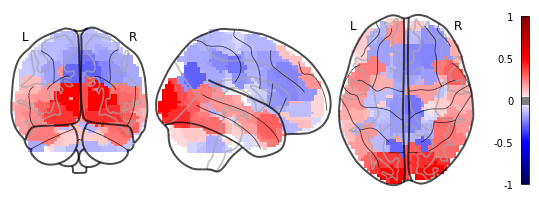

In [31]:
region_vector_v1 = np.zeros((1,268))
region_vector_v1[0, :] = avg_views_intra[0][0:268]

region_img_v1 = shen_masker.inverse_transform(region_vector_v1);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_v1,0), plot_abs=False, colorbar=True,vmax = 1., 
                                       cmap = 'seismic', );
plt.show()

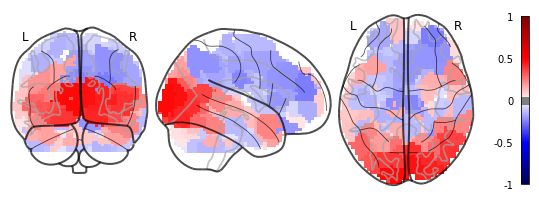

In [32]:
region_vector_v2 = np.zeros((1,268))
region_vector_v2[0, :] = avg_views_intra[1][0:268]

region_img_v2 = shen_masker.inverse_transform(region_vector_v2);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_v2,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

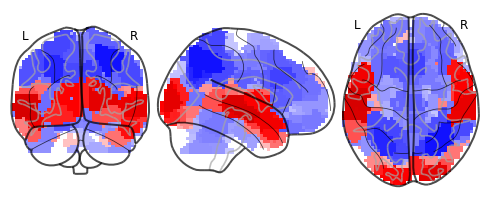

In [25]:
region_vector_v3 = np.zeros((1,268))
region_vector_v3[0, :] = avg_views_intra[2][0:268]

region_img_v3 = shen_masker.inverse_transform(region_vector_v3);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_v3,0),plot_abs=False, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

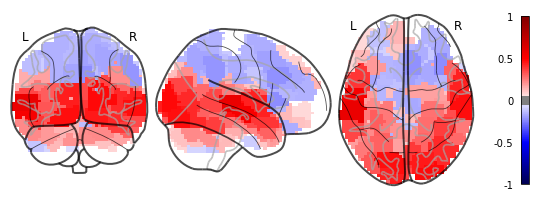

In [33]:
region_vector_v4 = np.zeros((1,268))
region_vector_v4[0, :] = avg_views_intra[3][0:268]

region_img_v4 = shen_masker.inverse_transform(region_vector_v4);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_v4,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

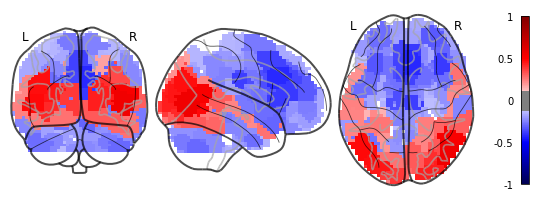

In [35]:
region_vector_v5 = np.zeros((1,268))
region_vector_v5[0, :] = avg_views_intra[4][0:268]

region_img_v5 = shen_masker.inverse_transform(region_vector_v5);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_v5,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

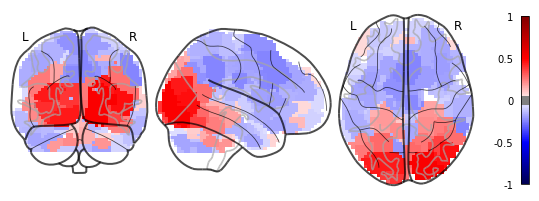

In [36]:
region_vector_v6 = np.zeros((1,268))
region_vector_v6[0, :] = avg_views_intra[5][0:268]

region_img_v6 = shen_masker.inverse_transform(region_vector_v6);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_v6,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

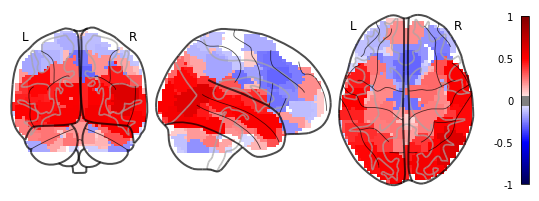

In [37]:
region_vector_v7 = np.zeros((1,268))
region_vector_v7[0, :] = avg_views_intra[6][0:268]

region_img_v7 = shen_masker.inverse_transform(region_vector_v7);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_v7,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

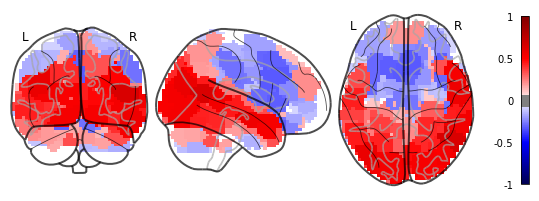

In [38]:
region_vector_v8 = np.zeros((1,268))
region_vector_v8[0, :] = avg_views_intra[7][0:268]

region_img_v8 = shen_masker.inverse_transform(region_vector_v8);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_v8,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

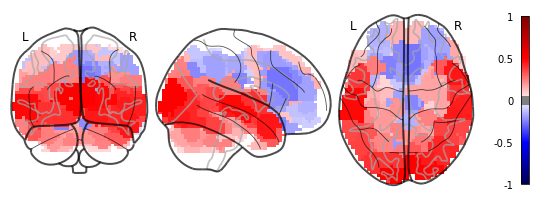

In [39]:
region_vector_v9 = np.zeros((1,268))
region_vector_v9[0, :] = avg_views_intra[8][0:268]

region_img_v9 = shen_masker.inverse_transform(region_vector_v9);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_v9,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

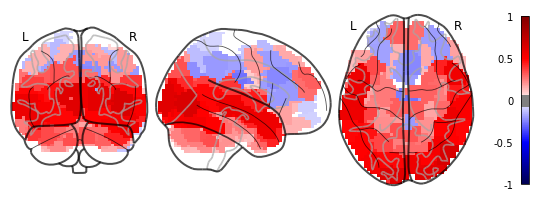

In [40]:
region_vector_v10 = np.zeros((1,268))
region_vector_v10[0, :] = avg_views_intra[9][0:268]

region_img_v10 = shen_masker.inverse_transform(region_vector_v10);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_v10,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

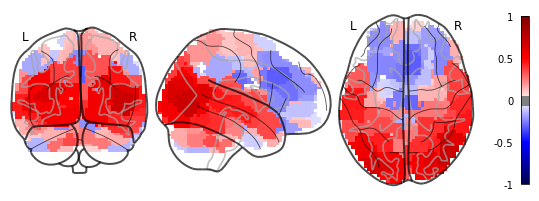

In [41]:
region_vector_v11 = np.zeros((1,268))
region_vector_v11[0, :] = avg_views_intra[10][0:268]

region_img_v11 = shen_masker.inverse_transform(region_vector_v11);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_v11,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

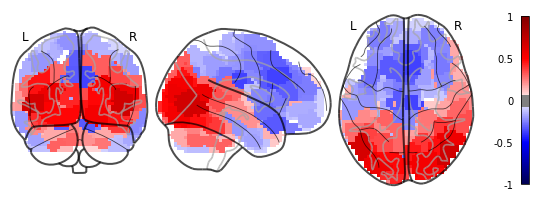

In [42]:
region_vector_v12 = np.zeros((1,268))
region_vector_v12[0, :] = avg_views_intra[11][0:268]

region_img_v12 = shen_masker.inverse_transform(region_vector_v12);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_v12,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

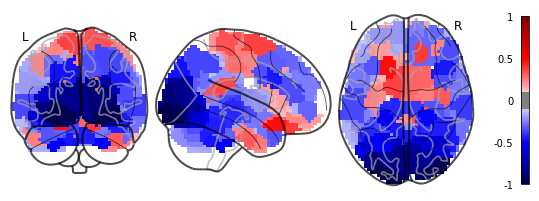

In [43]:
region_vector_i1 = np.zeros((1,268))
region_vector_i1[0, :] = avg_imagine_intra[0][0:268]

region_img_i1 = shen_masker.inverse_transform(region_vector_i1);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_i1,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

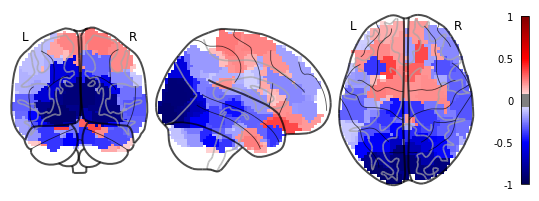

In [45]:
region_vector_i2 = np.zeros((1,268))
region_vector_i2[0, :] = avg_imagine_intra[1][0:268]

region_img_i2 = shen_masker.inverse_transform(region_vector_i2);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_i2,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

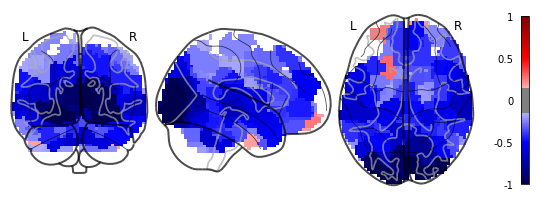

In [44]:
region_vector_i3 = np.zeros((1,268))
region_vector_i3[0, :] = avg_imagine_intra[2][0:268]

region_img_i3 = shen_masker.inverse_transform(region_vector_i3);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_i3,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

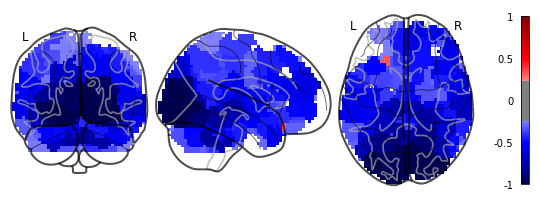

In [46]:
region_vector_i4 = np.zeros((1,268))
region_vector_i4[0, :] = avg_imagine_intra[3][0:268]

region_img_i4 = shen_masker.inverse_transform(region_vector_i4);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_i4,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

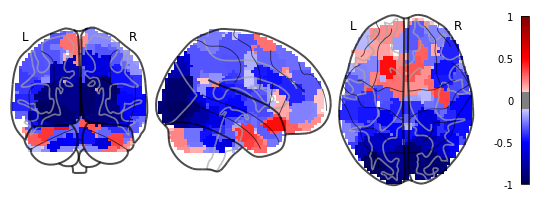

In [47]:
region_vector_i5 = np.zeros((1,268))
region_vector_i5[0, :] = avg_imagine_intra[4][0:268]

region_img_i5 = shen_masker.inverse_transform(region_vector_i5);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_i5,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

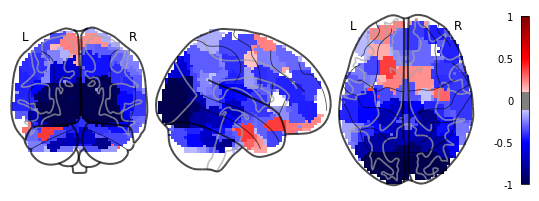

In [48]:
region_vector_i6 = np.zeros((1,268))
region_vector_i6[0, :] = avg_imagine_intra[5][0:268]

region_img_i6 = shen_masker.inverse_transform(region_vector_i6);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_i6,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

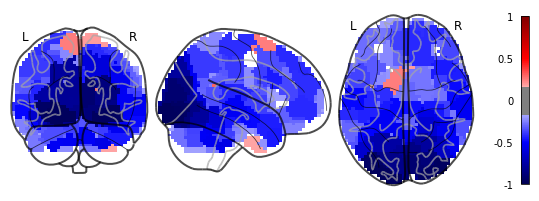

In [49]:
region_vector_i7 = np.zeros((1,268))
region_vector_i7[0, :] = avg_imagine_intra[6][0:268]

region_img_i7 = shen_masker.inverse_transform(region_vector_i7);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_i7,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

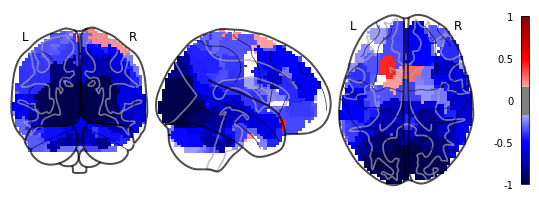

In [50]:
region_vector_i8 = np.zeros((1,268))
region_vector_i8[0, :] = avg_imagine_intra[7][0:268]

region_img_i8 = shen_masker.inverse_transform(region_vector_i8);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_i8,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

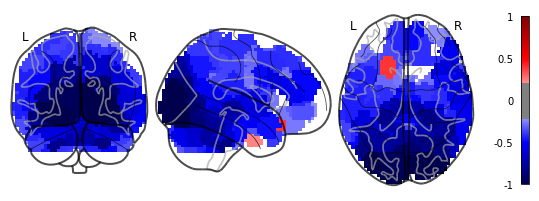

In [51]:
region_vector_i9 = np.zeros((1,268))
region_vector_i9[0, :] = avg_imagine_intra[8][0:268]

region_img_i9 = shen_masker.inverse_transform(region_vector_i9);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_i9,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

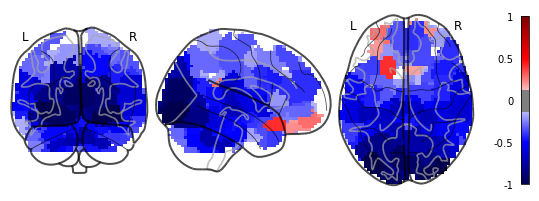

In [52]:
region_vector_i10 = np.zeros((1,268))
region_vector_i10[0, :] = avg_imagine_intra[9][0:268]

region_img_i10 = shen_masker.inverse_transform(region_vector_i10);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_i10,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

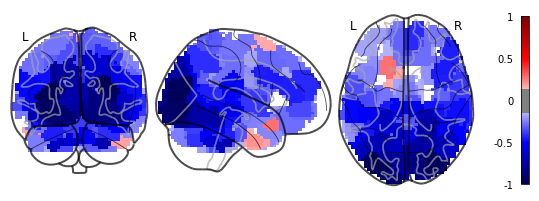

In [53]:
region_vector_i11 = np.zeros((1,268))
region_vector_i11[0, :] = avg_imagine_intra[10][0:268]

region_img_i11 = shen_masker.inverse_transform(region_vector_i11);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_i11,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()

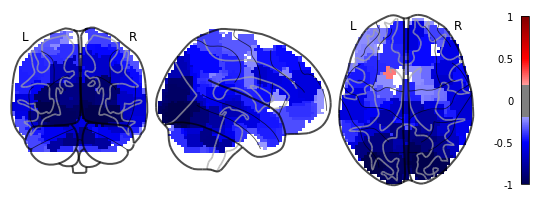

In [54]:
region_vector_i12 = np.zeros((1,268))
region_vector_i12[0, :] = avg_imagine_intra[11][0:268]

region_img_i12 = shen_masker.inverse_transform(region_vector_i12);

nilearn.plotting.plot_glass_brain(nilearn.image.index_img(region_img_i12,0),plot_abs=False, colorbar=True, vmax = 1., 
                                       cmap = 'seismic');
plt.show()